In [1]:
from rl4fisheries import Msy, ConstEsc, CautionaryRule, AsmEnv

In [2]:
import pandas as pd
import numpy as np

In [12]:
cr_gp = {'radius': 0.2195, 'theta': 0.4433, 'y2': 0.4106}
cr_gp_args = {}
cr_gp_args['x1'] = cr_gp['radius'] * np.sin(cr_gp['theta'])
cr_gp_args['x2'] = cr_gp['radius'] * np.cos(cr_gp['theta'])
cr_gp_args['y2'] = cr_gp['y2']

cr_gbrt = {'radius': 0.3724, 'theta':0.4228, 'y2':0.4207}
cr_gbrt_args = {}
cr_gbrt_args['x1'] = cr_gbrt['radius'] * np.sin(cr_gbrt['theta'])
cr_gbrt_args['x2'] = cr_gbrt['radius'] * np.cos(cr_gbrt['theta'])
cr_gbrt_args['y2'] = cr_gbrt['y2']

msy_gp_args = {'mortality': 0.0368}
msy_gbrt_args = {'mortality': 0.0261}

esc_gp_args = {'escapement': 0.1718}
esc_gbrt_args = {'escapement': 0.1596}

In [13]:
env = AsmEnv(config = {'s':0.97})

In [14]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

cr_gp_pol = CautionaryRule(env, **cr_gp_args)
esc_gp_pol = ConstEsc(env, **esc_gp_args)
msy_gp_pol = Msy(env, **msy_gp_args)

cr_gbrt_pol = CautionaryRule(env, **cr_gbrt_args)
esc_gbrt_pol = ConstEsc(env, **esc_gbrt_args)
msy_gbrt_pol = Msy(env, **msy_gbrt_args)

# Policy plots

In [15]:
def get_policy_df(policy_obj, minx=-1, maxx=1, nx=100):
    obs_list = np.linspace(minx, maxx, nx)
    return pd.DataFrame(
        {
            'obs': obs_list,
            'pop': (obs_list + 1)/2,
            'pol': [policy_obj.predict(obs)[0][0] for obs in obs_list]
        }
    )

In [20]:
cr_gbrt_df = get_policy_df(CautionaryRule(env, **cr_gbrt_args))
cr_gp_df = get_policy_df(CautionaryRule(env, **cr_gp_args))

(<Axes: title={'center': 'Cautionary Rule GP policy'}, xlabel='pop'>,
 <Axes: title={'center': 'Cautionary Rule GBRT policy'}, xlabel='pop'>)

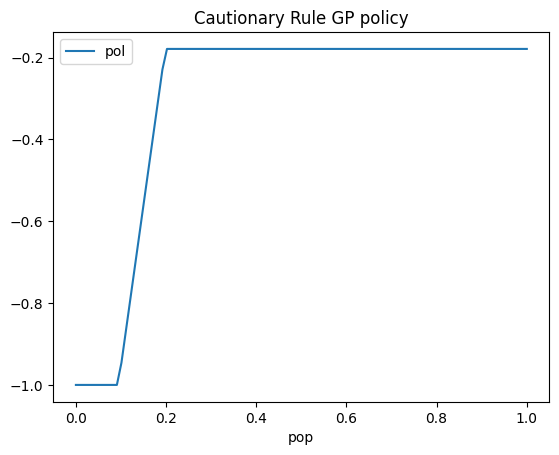

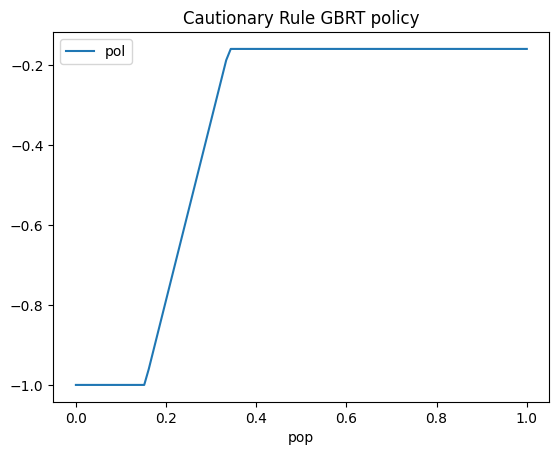

In [21]:
(
    cr_gp_df.plot(x='pop', y='pol', title='Cautionary Rule GP policy'),
    cr_gbrt_df.plot(x='pop', y='pol', title='Cautionary Rule GBRT policy'),
)    

In [24]:
esc_gbrt_df = get_policy_df(ConstEsc(env, **esc_gbrt_args))
esc_gp_df = get_policy_df(ConstEsc(env, **esc_gp_args))

(<Axes: title={'center': 'Constant Escapement GP policy'}, xlabel='pop'>,
 <Axes: title={'center': 'Constant Escapement GBRT policy'}, xlabel='pop'>)

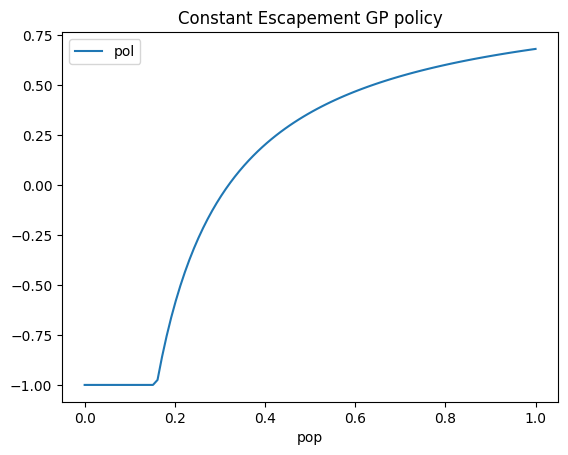

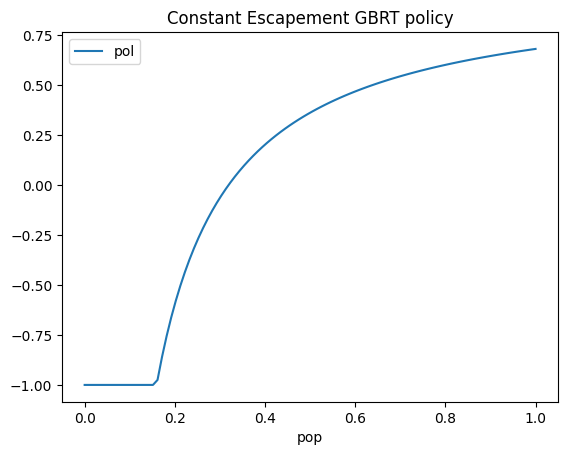

In [25]:
(
    esc_gbrt_df.plot(x='pop', y='pol', title='Constant Escapement GP policy'),
    esc_gbrt_df.plot(x='pop', y='pol', title='Constant Escapement GBRT policy')
)

# Reward distributions

In [26]:
cr_gp_rews = evaluate_policy(cr_gp_pol, Monitor(env), return_episode_rewards=True, n_eval_episodes=100)[0]
cr_gbrt_rews = evaluate_policy(cr_gbrt_pol, Monitor(env), return_episode_rewards=True, n_eval_episodes=100)[0]

esc_gp_rews = evaluate_policy(esc_gp_pol, Monitor(env), return_episode_rewards=True, n_eval_episodes=100)[0]
esc_gbrt_rews = evaluate_policy(esc_gbrt_pol, Monitor(env), return_episode_rewards=True, n_eval_episodes=100)[0]

msy_gp_rews = evaluate_policy(msy_gp_pol, Monitor(env), return_episode_rewards=True, n_eval_episodes=100)[0]
msy_gbrt_rews = evaluate_policy(msy_gbrt_pol, Monitor(env), return_episode_rewards=True, n_eval_episodes=100)[0]

In [29]:
rew_df = pd.DataFrame({
    'CautionaryRule_gp': cr_gp_rews,
    'CautionaryRule_gbrt': cr_gbrt_rews,
    'Escapement_gp': esc_gp_rews,
    'Escapement_gbrt': esc_gbrt_rews,
    'MSY_gp': msy_gp_rews,
    'MSY_gbrt': msy_gbrt_rews,
}).melt()

In [45]:
rew_df['optimization'] = rew_df.apply(lambda row: 'gp' if row.variable[-2:]=='gp' else 'gbrt', axis=1)
rew_df.head()

,variable,value,optimization
0,CautionaryRule_gp,231.675426,gp
1,CautionaryRule_gp,230.102295,gp
2,CautionaryRule_gp,228.520022,gp
3,CautionaryRule_gp,230.469030,gp
4,CautionaryRule_gp,231.865324,gp


In [36]:
from plotnine import ggplot, aes, geom_density

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:779: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


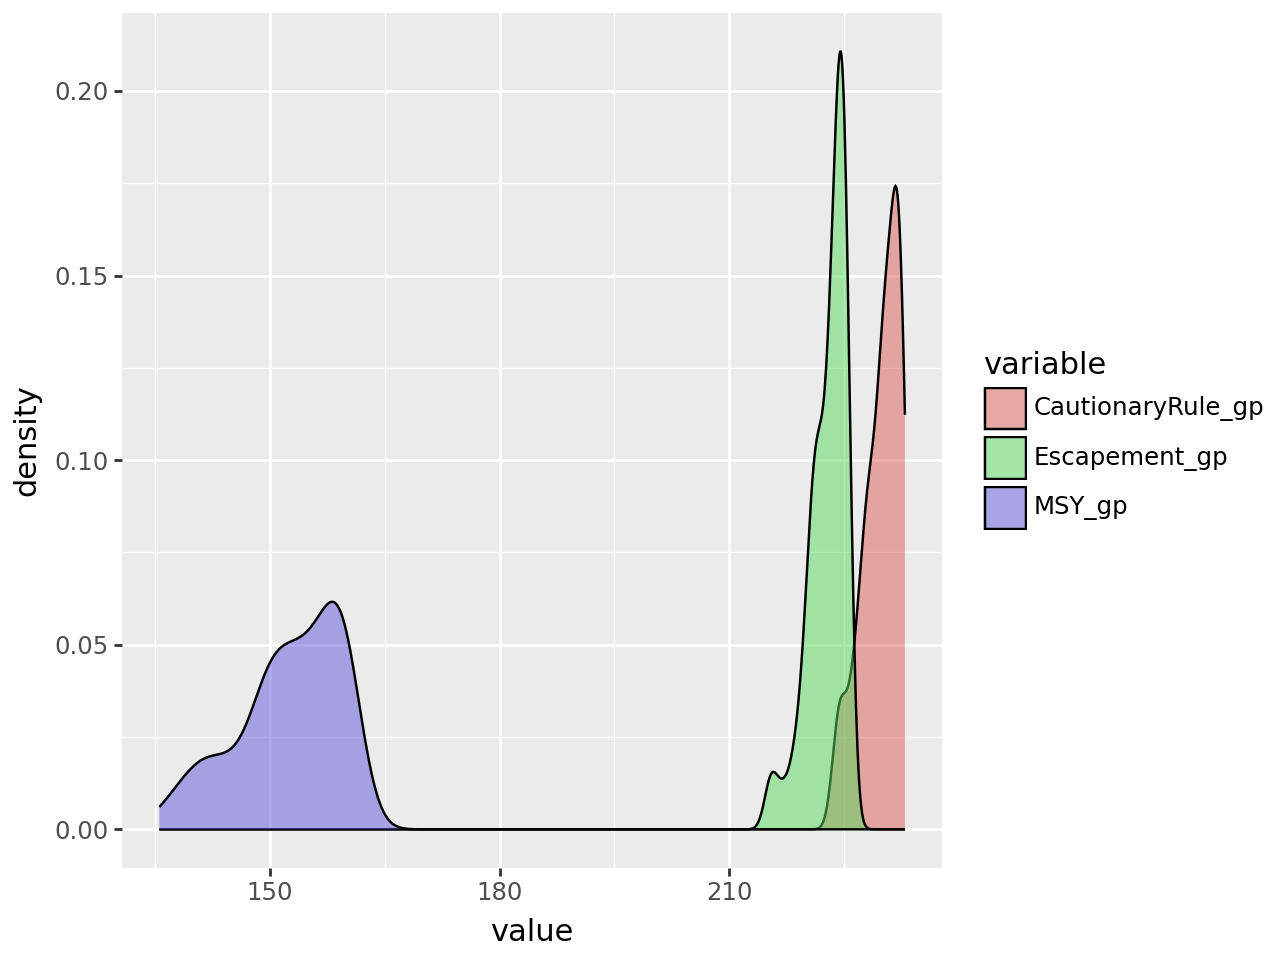

(<Figure Size: (640 x 480)>,)

In [48]:
ggplot(rew_df[rew_df["optimization"] == 'gp'], aes(x='value', fill='variable')) + geom_density(alpha=0.5),

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:779: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


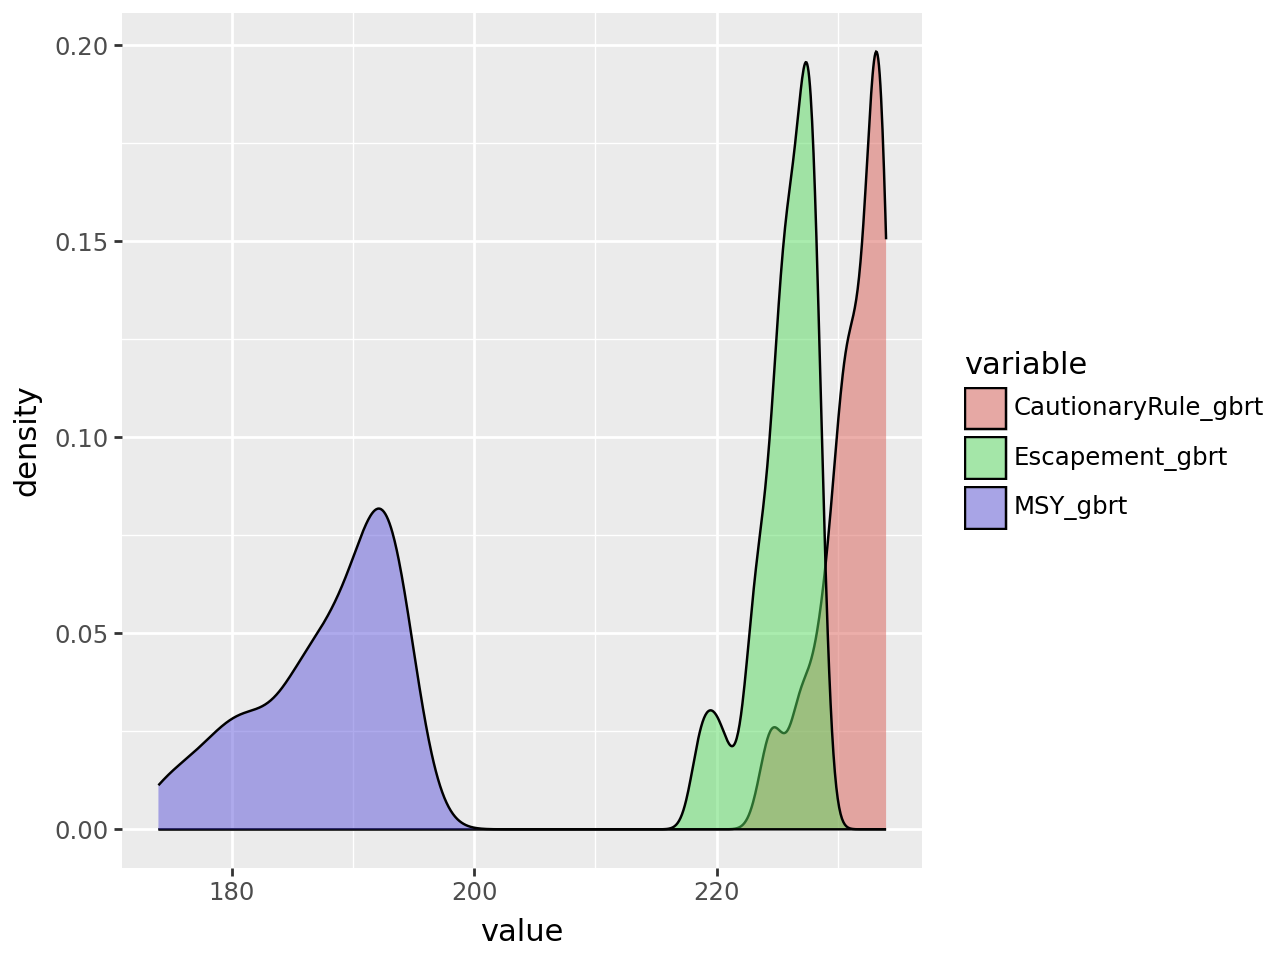

(<Figure Size: (640 x 480)>,)

In [49]:
ggplot(rew_df[rew_df["optimization"] == 'gbrt'], aes(x='value', fill='variable')) + geom_density(alpha=0.5),

# Timeseries

In [50]:
from typing import List, Text, Optional

def simulate_ep(env, agent, other_vars: Optional[List[Text]] = []):   
    simulation = {
        't': [],
        'surv_b_obs': [],
        'mean_wt_obs': [],
        'act': [],
        'rew': [],
        'total_pop': [],
        'newborns': [],
        'non_random_newb': [],
        **{var_name: [] for var_name in other_vars}
    }
    obs, _ = env.reset()
    for t in range(env.Tmax):
        act, _ = agent.predict(obs)
        new_obs, rew, term, trunc, info = env.step(act)
        #
        simulation['t'].append(t)
        simulation['surv_b_obs'].append(
            env.bound * (obs[0]+1)/2
        )
        simulation['mean_wt_obs'].append(
            (
                env.parameters["min_wt"]
                + (env.parameters["max_wt"] - env.parameters["min_wt"])
                * (obs[1]+1)/2
            )
        )
        simulation['act'].append(act[0])
        simulation['rew'].append(rew)
        simulation['total_pop'].append(np.sum(env.state))
        simulation['newborns'].append(env.state[0])
        simulation['non_random_newb'].append(
            env.parameters["bha"] * env.ssb / (1 + env.parameters["bhb"] * env.ssb)
        )
        for var_name in other_vars:
            simulation[var_name].append(getattr(env, var_name))
        #
        obs = new_obs
    #
    return simulation

In [56]:
from rl4fisheries.envs.asm_fns import get_r_devs

r_devs = get_r_devs(n_year=1000)
config = {'r_devs': r_devs, 's':0.97}

msy_ep = pd.DataFrame(simulate_ep(AsmEnv(config=config), msy_gp_pol, other_vars=['ssb']))
esc_ep = pd.DataFrame(simulate_ep(AsmEnv(config=config), esc_gp_pol, other_vars=['ssb']))
cr_ep = pd.DataFrame(simulate_ep(AsmEnv(config=config), cr_gp_pol, other_vars=['ssb']))

In [57]:
trivp = Msy(env = env, mortality=0)
trivial_ep = pd.DataFrame(simulate_ep(AsmEnv(config=config), trivp, other_vars=['ssb']))

## MSY plots

(<Axes: title={'center': 'reward = 175.690'}, xlabel='t'>,)

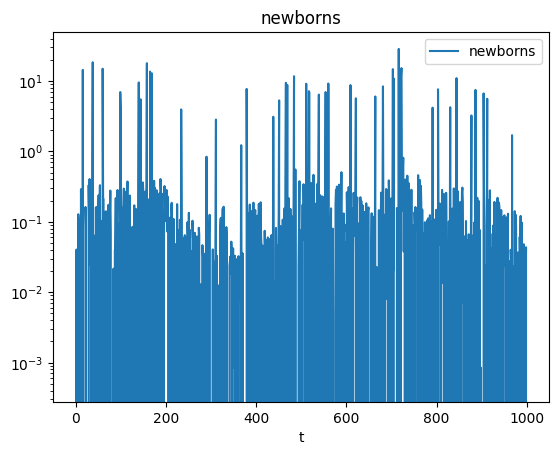

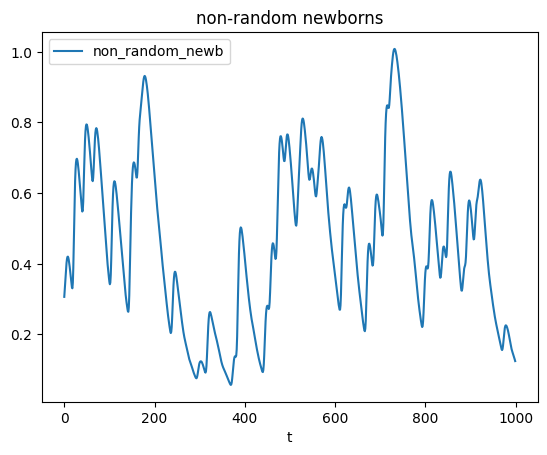

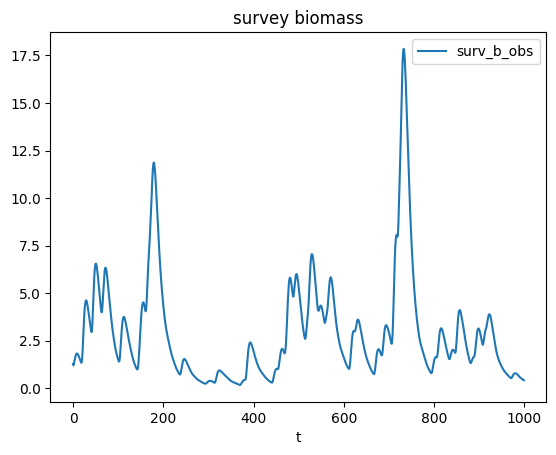

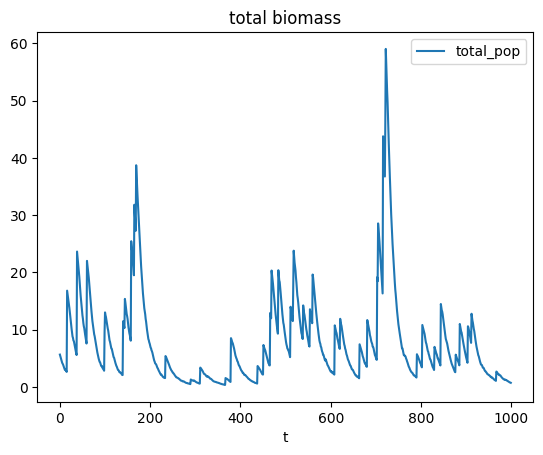

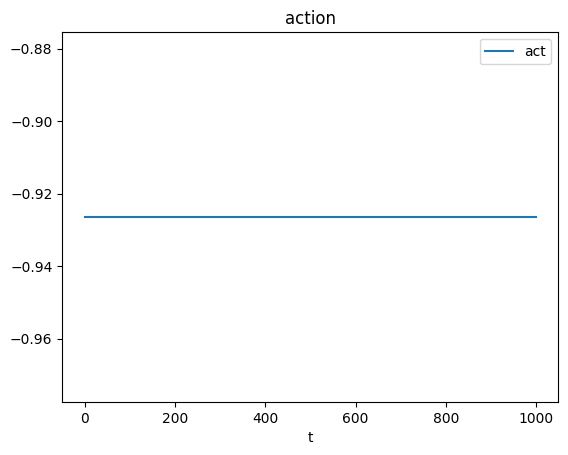

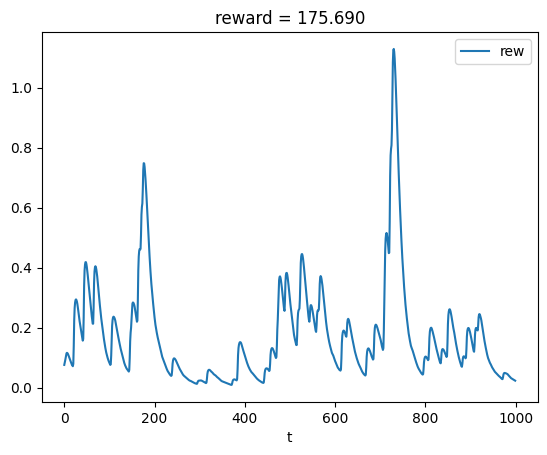

In [58]:
msy_ep.plot(x='t', y = ['newborns'], title='newborns', logy=True),
msy_ep.plot(x='t', y = ['non_random_newb'], title='non-random newborns'),
msy_ep.plot(x='t', y = ['surv_b_obs'], title='survey biomass'),
msy_ep.plot(x='t', y = ['total_pop'], title='total biomass'),
msy_ep.plot(x='t', y = ['act'], title='action'),
msy_ep.plot(x='t', y = ['rew'], title=f'reward = {sum(msy_ep.rew):.3f}'),

## Escapement

<Axes: title={'center': 'reward = 224.136'}, xlabel='t'>

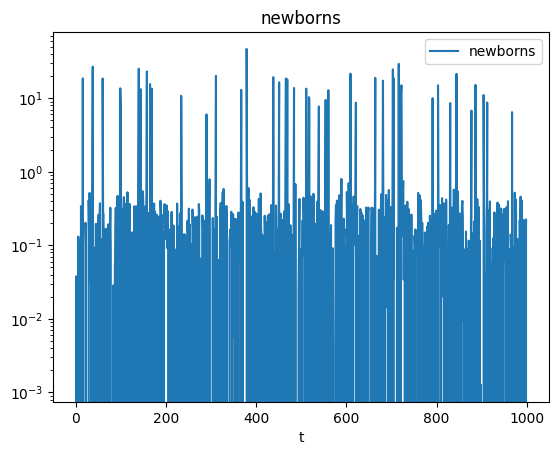

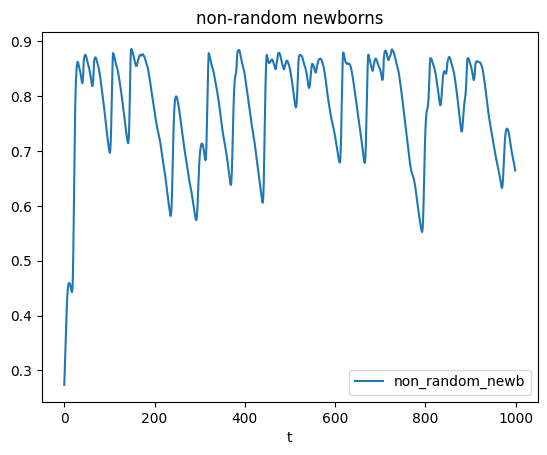

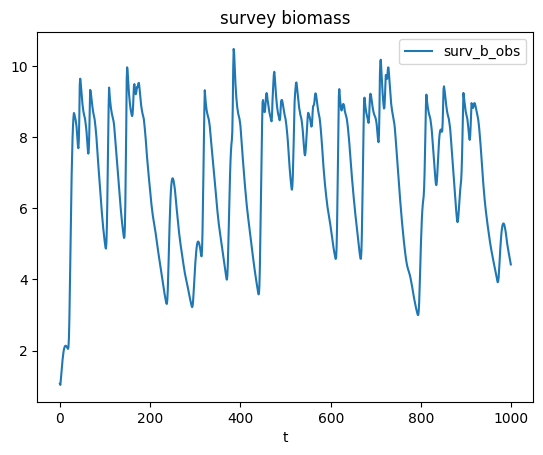

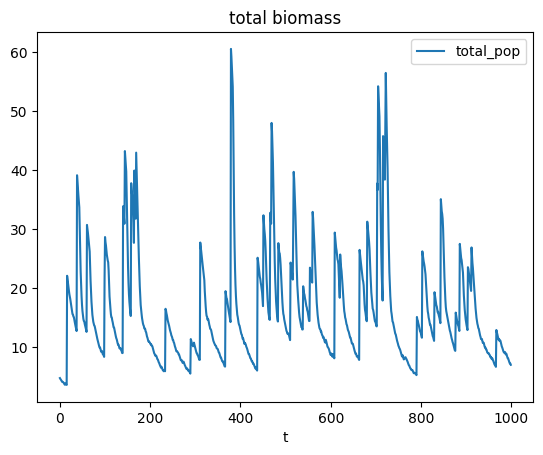

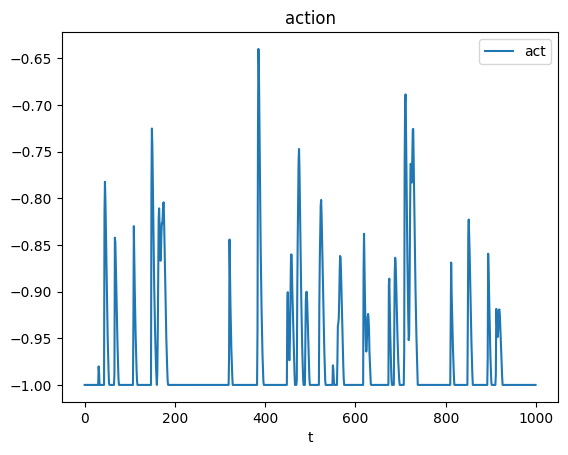

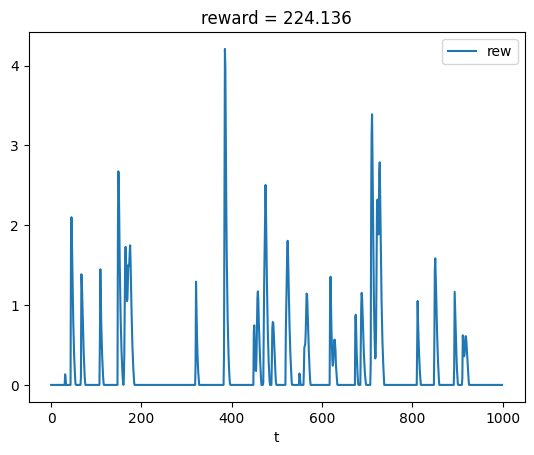

In [59]:
esc_ep.plot(x='t', y = ['newborns'], title='newborns', logy=True),
esc_ep.plot(x='t', y = ['non_random_newb'], title='non-random newborns'),
esc_ep.plot(x='t', y = ['surv_b_obs'], title='survey biomass'),
esc_ep.plot(x='t', y = ['total_pop'], title='total biomass'),
esc_ep.plot(x='t', y = ['act'], title='action'),
esc_ep.plot(x='t', y = ['rew'], title = f'reward = {sum(esc_ep.rew):.3f}')

## Cautionary Rule

<Axes: title={'center': 'reward = 235.796'}, xlabel='t'>

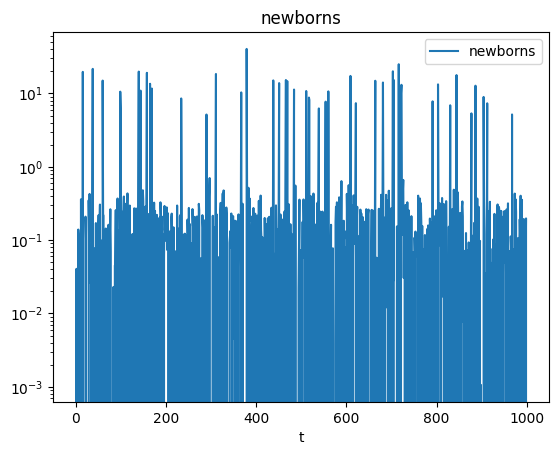

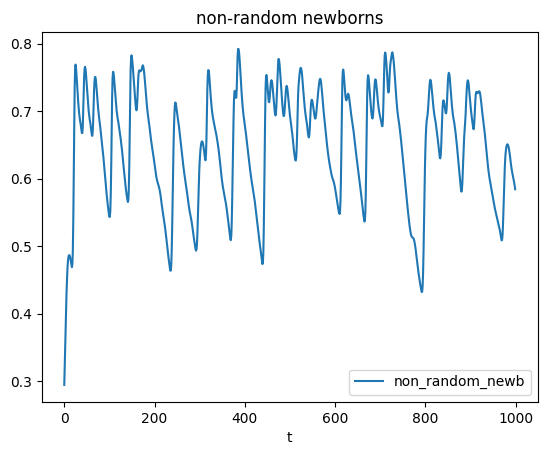

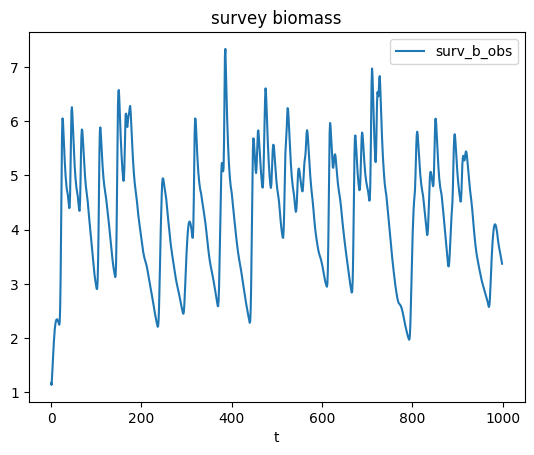

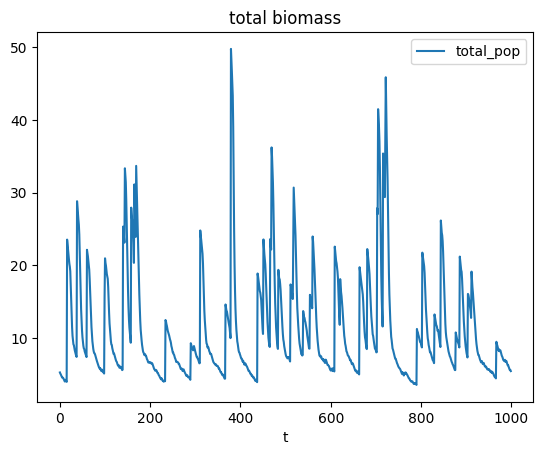

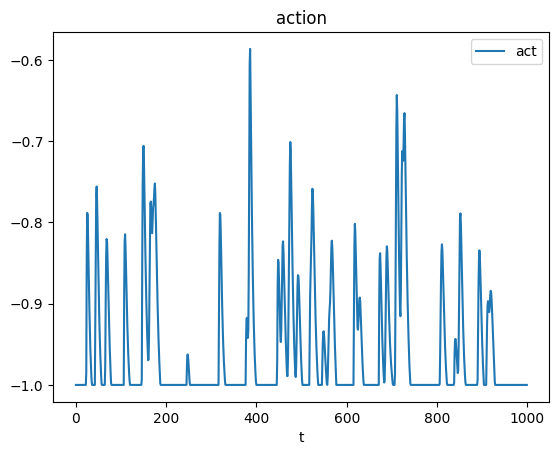

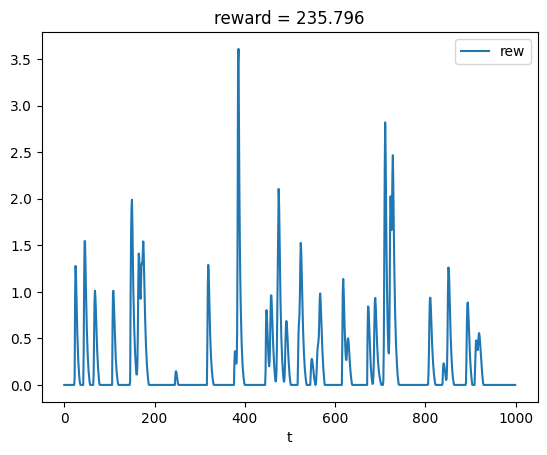

In [60]:
cr_ep.plot(x='t', y = ['newborns'], title='newborns', logy=True),
cr_ep.plot(x='t', y = ['non_random_newb'], title='non-random newborns'),
cr_ep.plot(x='t', y = ['surv_b_obs'], title='survey biomass'),
cr_ep.plot(x='t', y = ['total_pop'], title='total biomass'),
cr_ep.plot(x='t', y = ['act'], title='action'),
cr_ep.plot(x='t', y = ['rew'], title=f'reward = {sum(cr_ep.rew):.3f}')

## Trivial (no action)

<Axes: title={'center': 'reward = 0.000'}, xlabel='t'>

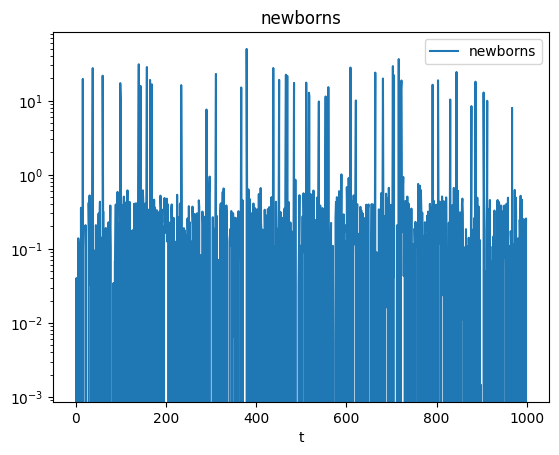

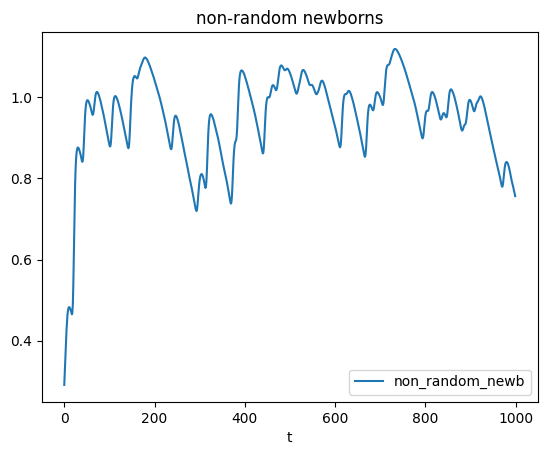

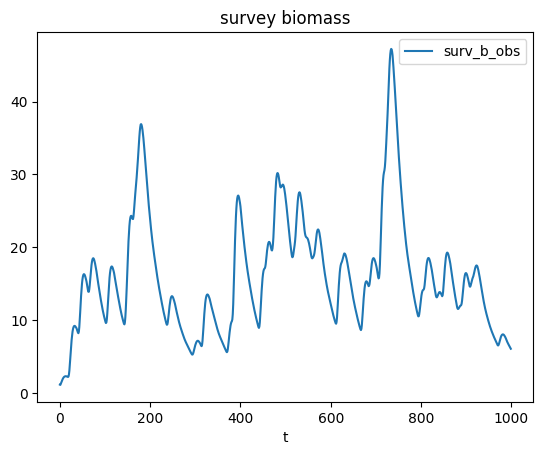

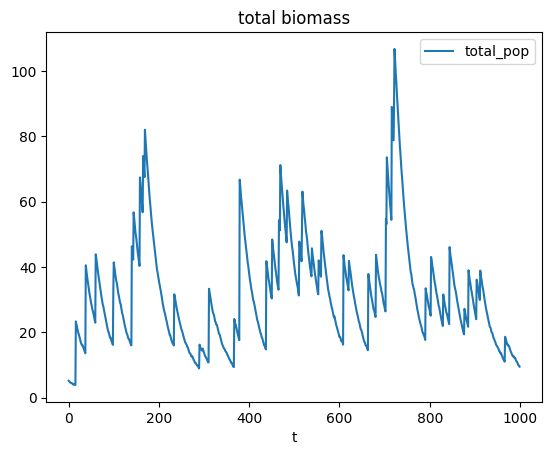

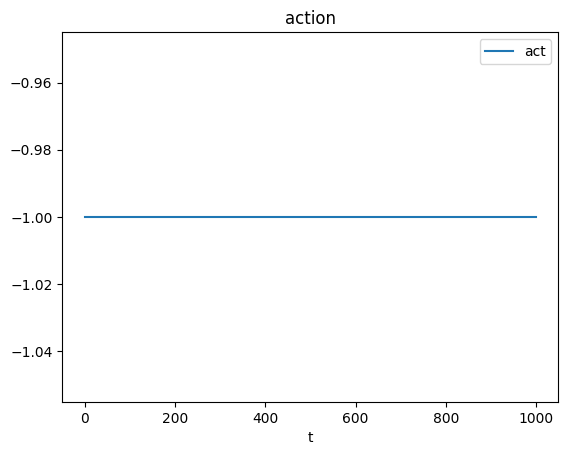

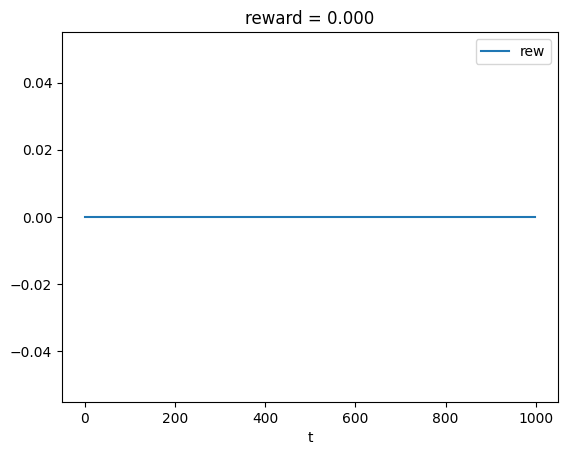

In [62]:
trivial_ep.plot(x='t', y = ['newborns'], title='newborns', logy=True),
trivial_ep.plot(x='t', y = ['non_random_newb'], title='non-random newborns'),
trivial_ep.plot(x='t', y = ['surv_b_obs'], title='survey biomass'),
trivial_ep.plot(x='t', y = ['total_pop'], title='total biomass'),
trivial_ep.plot(x='t', y = ['act'], title='action'),
trivial_ep.plot(x='t', y = ['rew'], title=f'reward = {sum(trivial_ep.rew):.3f}')

## Some side by side plots

(<Axes: title={'center': 'Unfished non-random newborns'}, xlabel='t'>,)

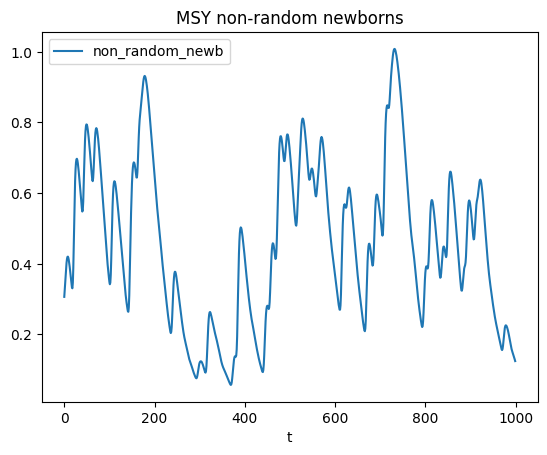

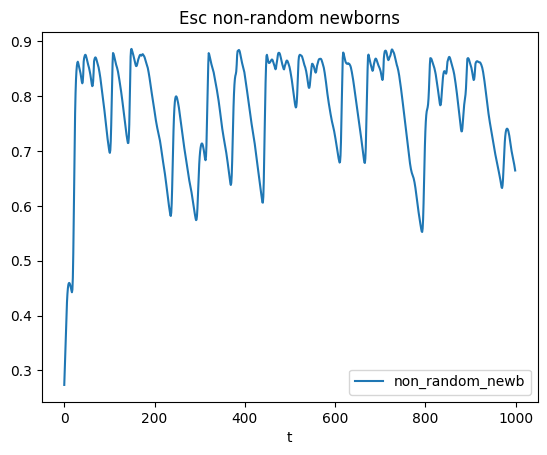

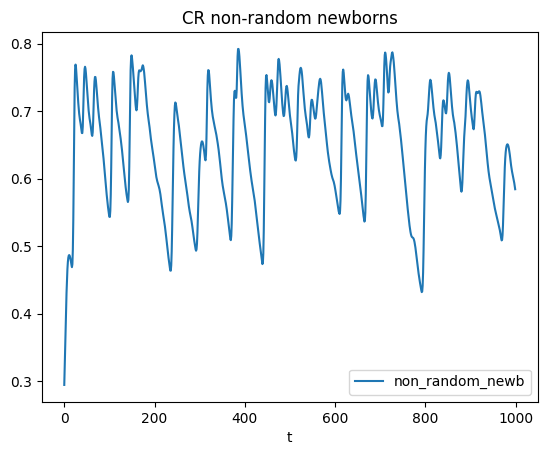

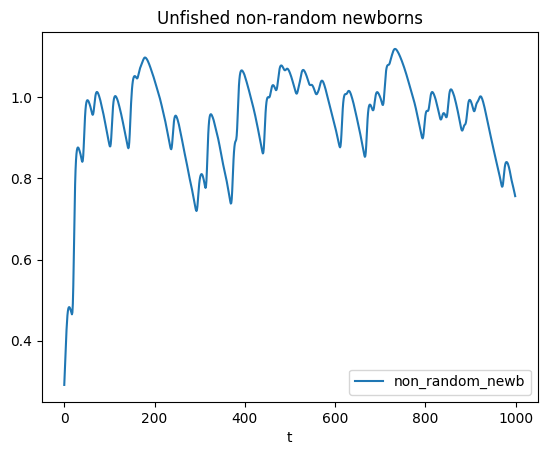

In [63]:
msy_ep.plot(x='t', y = ['non_random_newb'], title='MSY non-random newborns'),
esc_ep.plot(x='t', y = ['non_random_newb'], title='Esc non-random newborns'),
cr_ep.plot(x='t', y = ['non_random_newb'], title='CR non-random newborns'),
trivial_ep.plot(x='t', y = ['non_random_newb'], title='Unfished non-random newborns'),

# r_devs

<Axes: xlabel='t'>

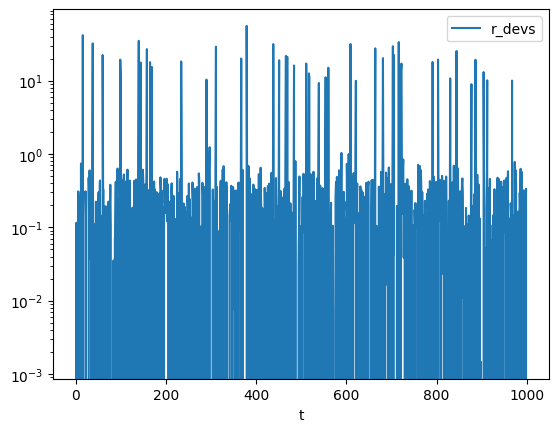

In [64]:
rdev_df = pd.DataFrame({
    't': list(range(len(r_devs))),
    'r_devs': r_devs,
})
rdev_df.plot(x='t', logy=True)

In [65]:
(
    len(rdev_df[rdev_df['r_devs']==0]),
    len(rdev_df[(rdev_df['r_devs']>0) & (rdev_df['r_devs']<=1e-1)]),
    len(rdev_df[(rdev_df['r_devs']<=1) & (rdev_df['r_devs']>1e-1)]),
    len(rdev_df[rdev_df['r_devs']>1]),
)

(468, 96, 390, 46)

So about half of the time (n=468/1000) it doesn't actually matter what `ssb` is, since the `r_dev` is just zero.
A bout 10% of the time, it *almost* doesn't matter either, since `r_dev<0.1` in this case.

Having a noise process that is mostly = 1 except for moments of deviation that are fewer in number might make the population dynamics not just reduce itself to the moments in which large schools happen.

Plus, adding some danger around having too-low a population would also potentially make things more interesting.
Currently the `ssb` doesn't really matter in a large percentage of time-steps.
If we fixed the noise to make `ssb` more meaningful, the agent might be more careful about overfishing a large school too early on.
If we add to that a danger of a low population going extinct (e.g. an additive noise term) we might get an agent who will try and keep a high enough `ssb` value at all times, especially during periods that lack large schools.